In [1]:
import osmnx as ox
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from simulated_annealing import sa

%matplotlib inline

In [2]:
class pub_crawl:
	def __init__(self, file, G) -> None:
		# pubs_file = 'galway_pubs.csv'
		self.G = G
		self.pubs_df = pd.read_csv(file)
		self.pub_names = self.pubs_df['name'].to_list()

		# create dictionary of pub names and coordinates
		self.pubs_dict = self.pubs_df.drop('address', axis=1).set_index('name').T.to_dict('list')

		self.create_pub_nodes()
		self.create_dist_dict()

	def create_pub_nodes(self):
		# Get graph nodes for each pub
		self.pub_nodes = {}
		for k, v in self.pubs_dict.items():
			self.pub_nodes[k] = ox.nearest_nodes(self.G, X = v[1], Y = v[0])
	
	def plot_map(self):
		node_colours = ['#FF0000' if i in list(self.pub_nodes.values()) else '#999999' for i in self.G.nodes]
		fig, ax = ox.plot_graph(self.G, bgcolor='#FFFFFF', node_color=node_colours, show=False, close=False)
		for _, node in ox.graph_to_gdfs(self.G, nodes=True, edges=False).fillna("").iterrows():
			for k, v in self.pub_nodes.items():
				if node.name == v:
					c = node["geometry"].centroid
					ax.annotate(k, xy=(c.x, c.y), xycoords='data', xytext=(3, -2), textcoords='offset points', size=8)
		plt.show()
	
	def get_route_length(self, p0, p1):
		'''
		Calculate length in meters between two pubs

		p0: Name of first pub
		p1: Name of second pub
		'''
		route = nx.shortest_path(self.G, self.pub_nodes[p0], self.pub_nodes[p1], weight='length')
		route_lengths = ox.utils_graph.get_route_edge_attributes(self.G, route, attribute = 'length')
		route_length_total = np.sum(route_lengths)
		return route_length_total
	
	def get_route_nodes(self, pubs_list):
		'''
		Returns list of all nodes within the shortest path between pubs

		pubs_order: List of pubs to visit ordered by first to last
		'''

		route = []
		for i in range(len(pubs_list)-1):
			route.append(nx.shortest_path(self.G, 
				 self.pub_nodes[pubs_list[i]], 
				 self.pub_nodes[pubs_list[i+1]], 
				 weight='length'))
		
		return route
	
	def create_dist_dict(self):
		self.dist_dict = {}
		for i in range(len(self.pub_names)):
			for j in range(len(self.pub_names)):
				if i == j: pass
				else:
					dst = self.get_route_length(self.pub_names[i], self.pub_names[j])
					self.dist_dict[self.pub_names[i], self.pub_names[j]] = dst
		return self.dist_dict
	
	def dist_total(self, pubs_list):
        # sequentially calculate distance between all tsp nodes
		dist = 0
		for i in range(len(pubs_list)-1): 
			dist += self.dist_dict[pubs_list[i], pubs_list[i+1]]
		return dist
	
	def get_initial_route(self):
		return self.pub_names

	def optimise_route(self):
		self.opt = sa.minimize(self.dist_total, self.pub_names, opt_mode='combinatorial', step_max=2000, t_max=1000, t_min=0)
		return self.opt.best_state
	
	def get_length(self, route):
		return self.dist_total(route)
	
	def plot_route(self, route):
		# Plot route
		route_nodes = self.get_route_nodes(route)
		fig, ax = ox.plot_graph_routes(self.G, route_nodes, bgcolor='#FFFFFF', show=False, close=False)
		for _, node in ox.graph_to_gdfs(self.G, nodes=True, edges=False).fillna("").iterrows():
			for i, k in enumerate(route):
				if node.name == self.pub_nodes[k]:
					c = node["geometry"].centroid
					ax.annotate(f'{i}: {k}', xy=(c.x, c.y), xycoords='data', xytext=(3, -2), textcoords='offset points', size=8)
		plt.show()

In [3]:
G =  ox.io.load_graphml('galway.graphml')

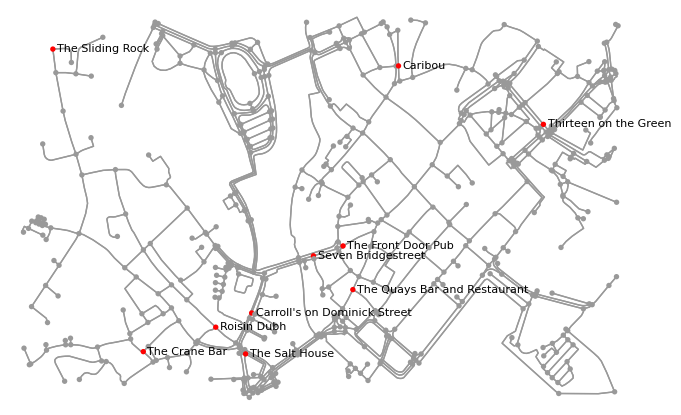

In [4]:
crawl = pub_crawl('galway_pubs.csv', G)

crawl.plot_map()

['The Crane Bar', 'The Quays Bar and Restaurant', 'Roisin Dubh', 'Seven Bridgestreet', 'The Front Door Pub', 'Caribou', 'The Salt House', "Carroll's on Dominick Street", 'Thirteen on the Green', 'The Sliding Rock']
5049.321999999999


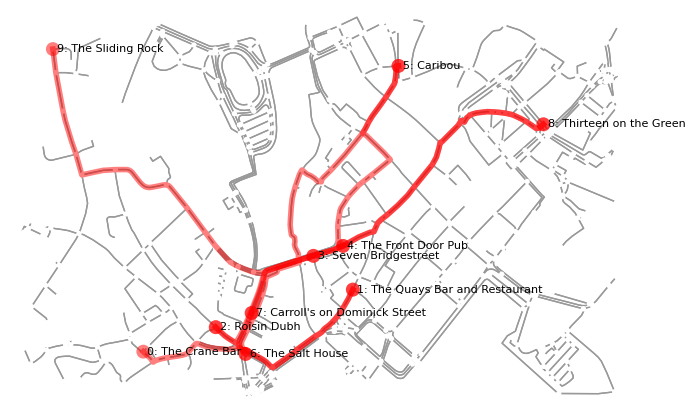

In [5]:
initial_route = crawl.get_initial_route()
print(initial_route)

initial_length = crawl.get_length(initial_route)
print(initial_length)

crawl.plot_route(initial_route)

['Thirteen on the Green', 'Caribou', 'The Front Door Pub', 'The Quays Bar and Restaurant', 'Seven Bridgestreet', "Carroll's on Dominick Street", 'The Salt House', 'Roisin Dubh', 'The Crane Bar', 'The Sliding Rock']
2509.021


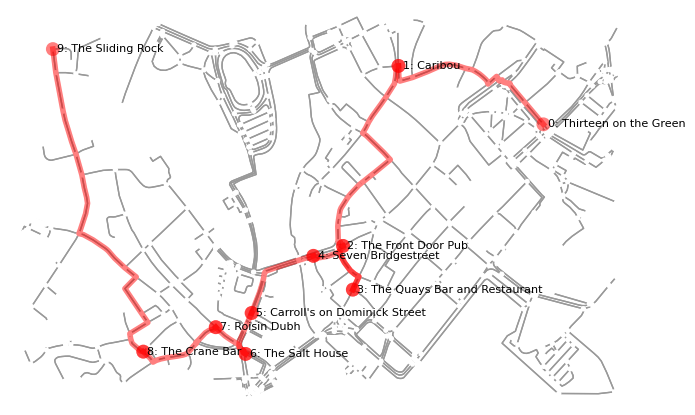

In [6]:
opt_route = crawl.optimise_route()
print(opt_route)

opt_length = crawl.get_length(opt_route)
print(opt_length)

crawl.plot_route(opt_route)